# Deep Convolution Network - Image Recognition - Flower
A simple convolution network for image reconition on the common flower set.

In [ ]:
%pip install -q keras-tuner numpy imageio pydot tensorflow-gpu==2.9.1 keras

In [2]:
import os
import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
import pathlib
import os.path
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        #mixed_precision.set_global_policy('mixed_float16')
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# initialize tf.distribute.MirroredStrategy
strategy = tf.distribute.MirroredStrategy(devices=None)
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070 Ti, compute capability 8.6


2022-06-05 11:03:28.808580: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-05 11:03:28.830361: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-05 11:03:28.830524: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-05 11:03:28.831100: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.9.1


### Configure Output Directory
Set the output directory where all the results will be storaged.

In [ ]:
root_dir = "result/flower_CNN_image_recognition"
if not os.path.exists(root_dir):
    os.mkdir(root_dir)

## Setup DataSet

In [5]:
def loadDataFlower(image_size, batch_size):
    def configure_for_performance(ds, AUTOTUNE):
        ds = ds.cache()
        ds = ds.prefetch(buffer_size=AUTOTUNE)
        return ds

    dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
    data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                       fname='flower_photos',
                                       cache_dir='.',
                                       untar=True)
    data_dir = pathlib.Path(data_dir)

    # Search and find number of elements within directory, recursively.
    image_count = len(list(data_dir.glob('**/*.??g')))
    print("{0}: Found {1} files".format(data_dir, image_count))

    #
    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        interpolation='bilinear',
        color_mode='rgb',
        follow_links=True,
        shuffle=True,
        image_size=image_size,
        batch_size=batch_size)

    class_names = train_ds.class_names

    #
    AUTOTUNE = tf.data.AUTOTUNE
    normalization_layer = tf.keras.layers.Rescaling(1. / 255.0)

    # Translate [0,255] -> [-1, 1]
    normalized_ds = configure_for_performance(train_ds.map(lambda x, y: (normalization_layer(x) * 2.0 - 1.0, y)),
                                              AUTOTUNE)

    return normalized_ds, class_names


In [6]:

IMAGE_SIZE = (192, 192)

EPOCH = 128
BUFFER_SIZE = 192

#
BATCH_SIZE_PER_REPLICA = 64
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

normalized_ds, classes = loadDataFlower(IMAGE_SIZE, BATCH_SIZE)


datasets/flower_photos: Found 3670 files
Found 3670 files belonging to 5 classes.


2022-06-05 11:03:29.315401: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-05 11:03:29.316287: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-05 11:03:29.316471: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-05 11:03:29.316599: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [ ]:
trainAug = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomZoom(
        height_factor=(-0.05, -0.10),
        width_factor=(-0.05, -0.10)),
    layers.RandomRotation(0.4)
])

trainX, trainY, classes = loadDataCifar100()
trainDS = tf.data.Dataset.from_tensor_slices((trainX, trainX))

def AgumentFunc(x, y):
    aX = trainAug(x)
    return (aX, y)

# apply augmentation image transformation to prevent overfitting of
trainAugmentedDS = (
    normalized_ds
    .batch(BATCH_SIZE)
    .map(AgumentFunc,
         num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

# Setup to support multiple GPUs
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
train_ds = train_ds.with_options(options)

## Show Example of DataSet

2022-06-05 11:05:25.980956: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


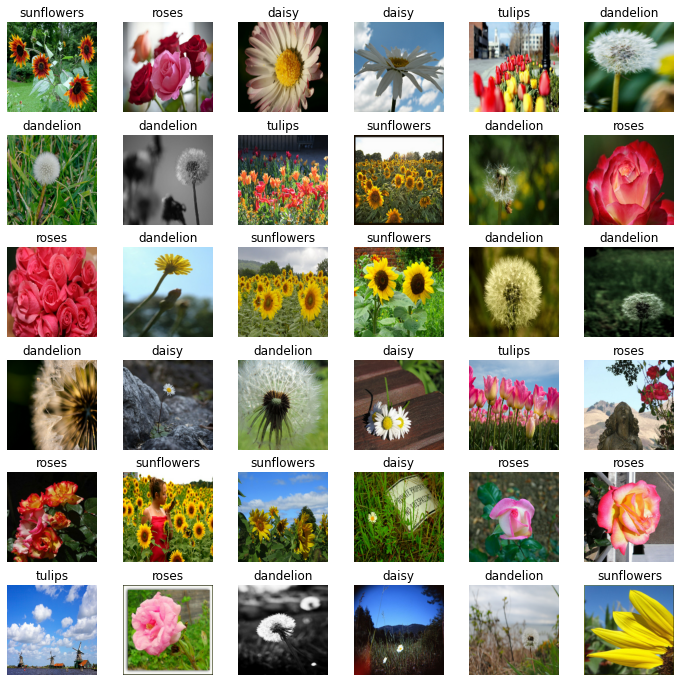

In [10]:
fig = plt.figure(figsize=(12, 12))
nrImage = 4 * 8
for images,label in normalized_ds.take(1):
    for i in range(36):
        ax = plt.subplot(6, 6, i + 1)
        # Transform pixel values from [-1,1] to [0,1]
        plt.title(label=str.format("{0}", classes[label[i]]))
        plt.imshow((images[i].numpy().astype(dtype='float32') + 1.0) / 2.0)
        plt.axis("off")

plt.subplots_adjust(wspace=0.25, hspace=0.25)
plt.show(block=False)


In [11]:
def plotCostHistory(history, loss_label="", val_label="", title="", x_label="", y_label=""):
    plt.figure()
    for k, v in history.items():
        plt.plot(v, label=k)
    plt.title(label=title)
    plt.ylabel(ylabel=y_label)
    plt.xlabel(xlabel=x_label)
    plt.legend(loc="upper left")
    plt.show()
    plt.savefig(title + ".png")


## Create Network with Hyperparameter
By using hyperparameter, a set of possible neuron network configuration can be setup. This allows to find network that are more optimal.

SparseCategoricalCrossentropy is used as the loss function. But also that it generates one-hot vector from an integer value that represents the categorical.

In [12]:

def generate_cnn_builder(hp, input, output):
    cnn_model = tf.keras.Sequential()
    #
    kernel_init = hp.Choice('kernel_initializer', ['uniform', 'lecun_uniform', 'normal', 'zero',
                                                   'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'])

    # TODO add stride.

    hp_kernel_filter_size_l0 = hp.Int('kernel_filter_size_0', min_value=16, max_value=96, step=16)
    hp_kernel_filter_size_l1 = hp.Int('kernel_filter_size_1', min_value=16, max_value=96, step=16)
    hp_kernel_filter_size_l2 = hp.Int('kernel_filter_size_2', min_value=16, max_value=96, step=16)

    hp_max_pooling_size_l0 = hp.Int('max_pooling_l0', min_value=1, max_value=4, step=1)
    hp_max_pooling_size_l1 = hp.Int('max_pooling_l1', min_value=1, max_value=4, step=1)
    hp_max_pooling_size_l2 = hp.Int('max_pooling_l2', min_value=1, max_value=4, step=1)

    cnn_model.add(
        layers.Conv2D(hp_kernel_filter_size_l0, (3, 3), kernel_initializer=kernel_init, activation='relu',
                      padding='same',
                      input_shape=input))
    cnn_model.add(layers.MaxPooling2D(pool_size=hp_max_pooling_size_l0))

    #
    cnn_model.add(
        layers.Conv2D(hp_kernel_filter_size_l1, (3, 3), activation='relu', kernel_initializer=kernel_init))
    cnn_model.add(layers.MaxPooling2D(pool_size=hp_max_pooling_size_l1))

    cnn_model.add(
        layers.Conv2D(hp_kernel_filter_size_l2, (3, 3), activation='relu', kernel_initializer=kernel_init))
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=hp_max_pooling_size_l2))

    cnn_model.add(layers.Flatten())

    hp_units = hp.Int('dense0_units', min_value=32, max_value=512, step=32)
    cnn_model.add(layers.Dense(units=hp_units, kernel_initializer=kernel_init))

    cnn_model.add(layers.Dense(output))

    cnn_model.summary()

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    cnn_model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                      loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])

    return cnn_model


## Training
First the dataset is split into training and test data.

kt.Hyperband is used as the hyperparameter manager, where the model_builder is the function that will construct the convolutional network.

tuner.search will search the whole hyperparameter space and select the one that is best, and to prevent it having to run all epoch, an EarlyStopping is used to valdiate if the model performance good or not in the early stage of the learning.

In [18]:
# Neuron network input and output.
image_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
num_classes_output = len(classes)


def model_builder(hp):
    model = generate_cnn_builder(hp, image_shape, num_classes_output)
    return model


tuner = kt.Hyperband(model_builder,
                     objective='accuracy',
                     max_epochs=16,
                     factor=3,
                     directory='cache',
                     project_name=str.format('cnn - {0}', "flower"))

stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='loss', patience=5)
tuner.search(normalized_ds, epochs=EPOCH, batch_size=BATCH_SIZE,
             callbacks=[stop_early], verbose=1)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_models = tuner.get_best_models(4)

cnn_model = tuner.hypermodel.build(best_hps)
cnn_model.summary()


Trial 30 Complete [00h 02m 22s]
accuracy: 0.9267029762268066

Best accuracy So Far: 0.9564032554626465
Total elapsed time: 00h 11m 17s
INFO:tensorflow:Oracle triggered exit


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 192, 192, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 192, 192, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 190, 190, 80)      11600     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 80)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 61, 61, 80)        57680     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 80)       0

## Training the Best Model
Now the best model that was selected is constructed and trained on.

In [19]:

checkpoint_path = "flower_cnn/cp.ckpt"

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0)

checkpoint = tf.train.Checkpoint(model=cnn_model)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path)).expect_partial()


# The model weights (that are considered the best) are loaded into the model.
if os.path.exists(checkpoint_path):
    cnn_model.load_weights(checkpoint_path)


cnn_model_history = cnn_model.fit(normalized_ds, epochs=EPOCH, batch_size=BATCH_SIZE)

cnn_model.save_weights(checkpoint_path)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 192, 192, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 192, 192, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 190, 190, 80)      11600     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 63, 63, 80)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 61, 61, 80)        57680     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 80)      

## Final Result

In [20]:
val_acc_per_epoch = cnn_model_history.history['accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: {0}'.format(best_epoch,))


Best epoch: 18


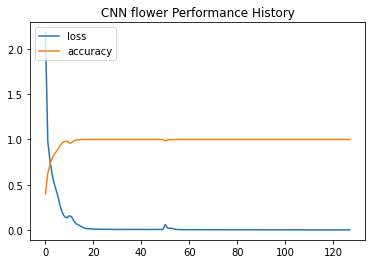

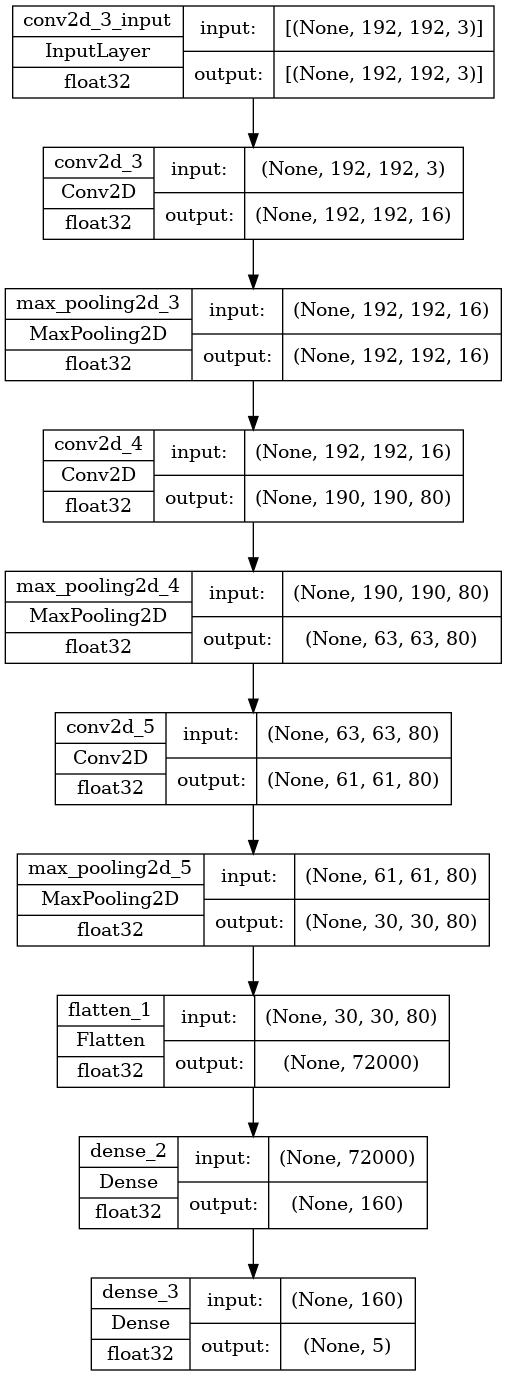

<Figure size 432x288 with 0 Axes>

In [21]:
plotCostHistory(cnn_model_history.history, title=str.format(
    "CNN {0} Performance History", "flower"))

tf.keras.utils.plot_model(
    cnn_model, to_file=str.format('cnn_{0}_model.png', "flower"), show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None
)
